## Inference/Sampling of the Image and Mask VAEs

In [1]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from connectomics.data.utils import readh5
from connectomics.config import get_cfg_defaults

import sys
sys.path.append("../")
from twostream.vae import VAE
from twostream.config import add_twostream_config
from twostream.dataset import VolumeDatasetCenterPatch
from twostream.utils import collate_fn_patch

# Load configs and build model
cfg_base = '../configs/JWR15/JWR15-VAE-2D-Base.yaml'
cfg_file_img = '../configs/JWR15/JWR15-VAE-2D-Image.yaml'
cfg_file_mask = '../configs/JWR15/JWR15-VAE-2D-Mask.yaml'

def get_config(cfg_base, cfg_file):
    cfg = get_cfg_defaults()
    add_twostream_config(cfg)
    cfg.merge_from_file(cfg_base)
    cfg.merge_from_file(cfg_file)
    return cfg

cfg_img = get_config(cfg_base, cfg_file_img)
cfg_mask = get_config(cfg_base, cfg_file_mask)

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def show(image, cmap='viridis', title='Test Title', interpolation=None):  
    num_imgs = image.shape[-3] # c (optional), z, y, x
    fig = plt.figure(figsize=(20., 3.))
    fig.suptitle(title, fontsize=14)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, num_imgs),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    image_list = np.split(image, num_imgs, -3)
    for ax, im in zip(grid, [np.squeeze(x) for x in image_list]):
        # Iterating over the grid returns the Axes.
        if im.ndim == 3:
            im = im.transpose(1,2,0)
        ax.imshow(im, cmap=cmap, interpolation=interpolation)
        ax.axis('off')

    plt.show()

In [3]:
def build_model(cfg, device, checkpoint):
    kwargs = {
        # defaults in pytorch-connectomics
        "img_channels": cfg.MODEL.IN_PLANES,
        "act_mode": cfg.MODEL.ACT_MODE,
        "norm_mode": cfg.MODEL.NORM_MODE,
        # unique ones in two-stream project
        "latent_dim": cfg.TWOSTREAM.LATENT_DIM,
        "hidden_dims": cfg.TWOSTREAM.HIDDEN_DIMS,
        "width": cfg.TWOSTREAM.WIDTH,
    }
    model = VAE(**kwargs)
    gpu_device_ids = list(range(torch.cuda.device_count()))
    model = nn.DataParallel(model, device_ids=gpu_device_ids)
    model = model.to(device)
    
    checkpoint = torch.load(checkpoint)
    model.module.load_state_dict(checkpoint['state_dict'])
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_img = build_model(cfg_img, device, "../../../outputs/JWR15_Syn_VAE_Image/checkpoint_400000.pth.tar")
vae_mask = build_model(cfg_mask, device, "../../../outputs/JWR15_Syn_VAE_Mask/checkpoint_400000.pth.tar")

### 1. Random Sampling

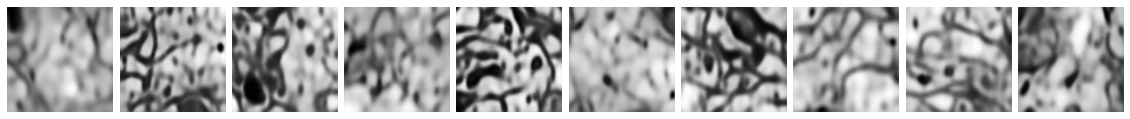

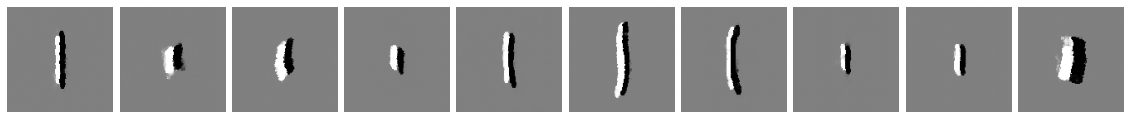

In [4]:
with torch.no_grad():
    sampled_img = vae_img.module.sample(10, device)
    sampled_mask = vae_mask.module.sample(10, device)
    show(sampled_img.cpu().numpy().transpose(1,0,2,3), title=None, cmap='gray')
    show(sampled_mask.cpu().numpy().transpose(1,0,2,3), title=None, cmap='gray')

### 2. Inference and Interpolation

In [5]:
# load volumes
img = readh5("../../../datasets/synapse/img.h5")
syn = readh5("../../../datasets/synapse/syn.h5")
ds = VolumeDatasetCenterPatch([syn], [img], label_type='syn', sample_size=128, mode='test')
loader = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=False, pin_memory=False,
                                     collate_fn=collate_fn_patch, num_workers=1)
loader = iter(loader)

Total number of samples to be generated:  111


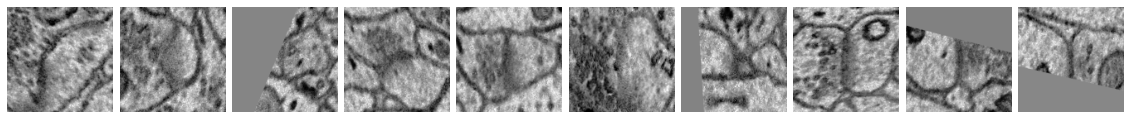

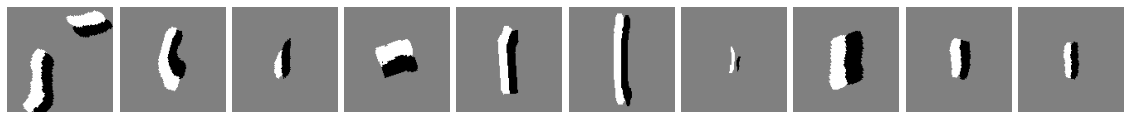

Shape of the image embedding: torch.Size([10, 1024])


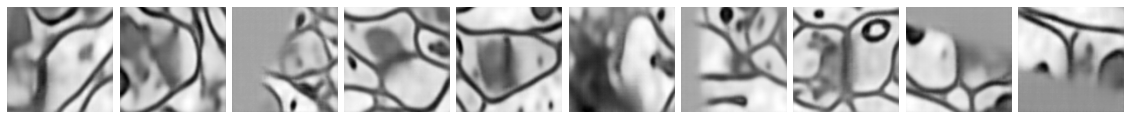

Shape of the mask embedding: torch.Size([10, 16])


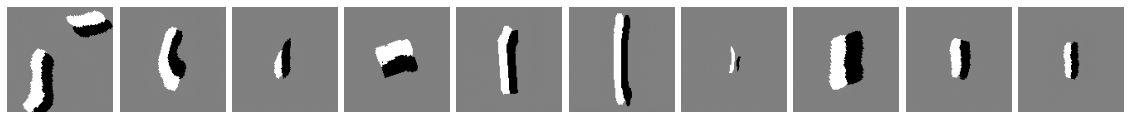

In [6]:
sample = next(loader)
img, seg = sample.img, sample.seg    
show(img.numpy().transpose(1,0,2,3), title=None, cmap='gray')
show(seg.numpy().transpose(1,0,2,3), title=None, cmap='gray') 

with torch.no_grad():
    mu, log_var = vae_img.module.encode(img.to(device))
    print(f"Shape of the image embedding: {mu.shape}")
    result = vae_img.module.decode(mu).detach().cpu()
    show(result.numpy().transpose(1,0,2,3), title=None, cmap='gray')

    mu, log_var = vae_mask.module.encode(seg.to(device))
    print(f"Shape of the mask embedding: {mu.shape}")
    result = vae_mask.module.decode(mu).detach().cpu()
    show(result.numpy().transpose(1,0,2,3), title=None, cmap='gray')

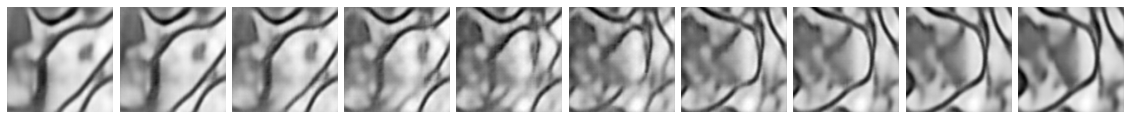

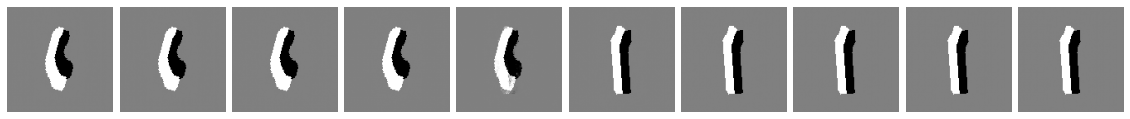

In [7]:
def interpolate(start, end, model):
    weights = np.linspace(0.0, 1.0, 10)
    with torch.no_grad():
        mu1, _ = model.module.encode(start)
        mu2, _ = model.module.encode(end)
        interpolated = [(1.0-a)*mu1 + a*mu2 for a in weights]
        interpolated = torch.cat(interpolated, 0)
        result = model.module.decode(interpolated).detach().cpu()
        show(result.numpy().transpose(1,0,2,3), title=None, cmap='gray')
        
interpolate(img[0:1].to(device), img[1:2].to(device), vae_img)
interpolate(seg[1:2].to(device), seg[4:5].to(device), vae_mask)